<a href="https://colab.research.google.com/github/berkearda/AlphaPoseTrain/blob/main/syntheticdatapreprocessingv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preprocessing Pipeline**

In [1]:
import cv2
import os
import zipfile
import json
import numpy as np

In [2]:
class DataLoader:
    def __init__(self, data_path):
        self.data_path = data_path

    def load_data(self):
        data = {}

        # Unzip the main zip file
        with zipfile.ZipFile(self.data_path, 'r') as zip_ref:
            zip_ref.extractall("/content/")

        # Process the extracted folder
        _, filename = os.path.split(self.data_path)  # split the path and filename
        folder_name, _ = os.path.splitext(filename)  # remove the .zip extension to get the folder name
        folder_path = os.path.join("/content/", folder_name)  # construct the folder path

        self._process_folder(folder_path, data)

        return data

    def _process_folder(self, folder_path, data):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            if file_name.endswith('.zip'):
                # This is a zip file, we need to extract it
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    extract_path = os.path.join(folder_path, os.path.splitext(file_name)[0])
                    zip_ref.extractall(extract_path)

                # Process the extracted folder
                extracted_folder_name = os.path.splitext(file_name)[0]
                extracted_folder_path = os.path.join(folder_path, extracted_folder_name)

                # Check if there's another nested folder with the same name
                if len(os.listdir(extracted_folder_path)) == 1 and \
                   os.path.isdir(os.path.join(extracted_folder_path, extracted_folder_name)):
                    extracted_folder_path = os.path.join(extracted_folder_path, extracted_folder_name)

                data[extracted_folder_name] = {}
                self._process_folder(extracted_folder_path, data[extracted_folder_name])

                # We can remove the zip file after extracting
                os.remove(file_path)

            elif file_name in ['view1', 'view2', 'view3', 'view4']:
                # This is a view directory, we need to process it
                view_path = os.path.join(folder_path, file_name)
                data[file_name] = {}
                self._process_view(view_path, data[file_name])

    def _process_view(self, view_path, data):
        for file_name in os.listdir(view_path):
            if file_name == 'json2d':
                # This is the json2d directory, we need to process it
                json2d_path = os.path.join(view_path, file_name)
                self._process_json2d(json2d_path, data)

            elif file_name == 'render':
                # This is the render directory, we need to process it
                render_path = os.path.join(view_path, file_name)
                self._process_render(render_path, data)

    def _process_json2d(self, json2d_path, data):
        for file_name in os.listdir(json2d_path):
            frame_number = os.path.splitext(file_name)[0]  # remove the .json extension to get the frame number
            frame_number = frame_number.split('_')[0]  # remove the '_keypoints' part

            if frame_number not in data:
                data[frame_number] = {}

            data[frame_number]['json_path'] = os.path.join(json2d_path, file_name)

    def _process_render(self, render_path, data):
        for file_name in os.listdir(render_path):
            frame_number = os.path.splitext(file_name)[0]  # remove the .png extension to get the frame number
            if frame_number not in data:
                data[frame_number] = {}

            data[frame_number]['image_path'] = os.path.join(render_path, file_name)


In [3]:
class Interpolator:
    def __init__(self):
        pass

    def interpolate(self, data):
        print("Starting interpolation...")
        for activity, views in data.items():
            print(f"Processing activity: {activity}")
            for view_name, frames in views.items():
                for frame_number, frame_data in frames.items():
                    # Load keypoints from JSON file
                    with open(frame_data['json_path'], 'r') as f:
                        keypoints = json.load(f)

                    # Check that keypoints list has enough elements (65 in this case)
                    if len(keypoints) < 65:
                        print(f"Insufficient keypoints in activity: {activity}, view: {view_name}, frame: {frame_number}. Skipping frame.")
                        continue

                    self._interpolate_keypoints(activity, view_name, frame_number, keypoints, data)

        return data

    def _interpolate_keypoints(self, activity, view, frame_number, keypoints, data):
        # Convert keypoints to float
        keypoints = [[float(coord) for coord in kp] for kp in keypoints]

        # Define the keypoints to use for the interpolation
        head = np.array(keypoints[0])  # 0th keypoint
        neck = np.array(keypoints[1])  # 1st keypoint
        top_head = np.array(keypoints[17])  # 17th keypoint

        # Calculate the direction from neck to head
        head_dir = head - neck

        # Normalize the head direction
        norm = np.linalg.norm(head_dir)
        # If the norm is zero or very close to zero, calculate direction from top_head to head instead

        if norm < 1e-6:
            head_dir = head - top_head
            norm = np.linalg.norm(head_dir)

        # If the norm is still zero or very close to zero, set ears and eyes to the head position
        if norm < 1e-6:
            left_ear = right_ear = left_eye = right_eye = head.tolist()
        else:
            # Normalize the head direction
            head_dir /= norm

            # Define the line shift for eyes and ears
            eye_vertical_shift = 0.4 * np.linalg.norm(head - neck)  # Adjust this value to change eye level
            ear_vertical_shift = 0.2 * np.linalg.norm(head - neck)  # Adjust this value to change ear level
            eye_horizontal_shift = 0.1 * np.linalg.norm(head - neck)  # Adjust this value to shift eyes left or right
            ear_horizontal_shift = 0.2 * np.linalg.norm(head - neck)  # Adjust this value to shift ears left or right

            # The line perpendicular to the head-neck line
            perp_line = np.array([-head_dir[1], head_dir[0]])

            # Calculate positions of the right eye and right ear
            right_ear = head + ear_vertical_shift * head_dir - (0.9 * np.linalg.norm(head - neck) - ear_horizontal_shift) * perp_line
            right_eye = head + eye_vertical_shift * head_dir - (0.6 * np.linalg.norm(head - neck) - eye_horizontal_shift) * perp_line

            # Mirror the right keypoints across the perpendicular line to get the left keypoints
            left_ear = self._mirror_point(right_ear, head, head + perp_line)
            left_eye = self._mirror_point(right_eye, head, head + perp_line)

        # Append the interpolated keypoints at the end of the keypoints list
        keypoints.extend([
            [round(coord, 1) for coord in left_ear],
            [round(coord, 1) for coord in right_ear],
            [round(coord, 1) for coord in left_eye],
            [round(coord, 1) for coord in right_eye]
        ])

        # Save the interpolated keypoints back to the data
        data[activity][view][frame_number]['keypoints'] = keypoints


    @staticmethod
    def _mirror_point(p, a, b):
        """
        Mirror the point `p` across the line defined by points `a` and `b`.
        """
        # Vector from a to p
        ap = p - a

        # Vector from a to b
        ab = b - a
        ab /= np.linalg.norm(ab)

        # Project ap onto ab
        proj = np.dot(ap, ab) * ab

        # Subtract twice the projection from ap
        mirrored = ap - 2 * proj

        return mirrored + a


In [4]:
class CocoFormatter:
    DEFAULT_VISIBILITY = 2

    def __init__(self):
        self.coco_data = {
            "info": {
                "description": "Your dataset description",
                "url": "Your dataset URL",
                "version": "1.0",
                "year": 2023,
                "contributor": "Your name",
                "date_created": "2023/07/24"
            },
            "licenses": [
                {
                    "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
                    "id": 1,
                    "name": "Attribution-NonCommercial-ShareAlike License"
                }
            ],
            "images": [],
            "annotations": [],
            "categories": [
                {
                    "supercategory": "person",
                    "id": 1,
                    "name": "person",
                    "keypoints": [
                        "nose",
                        "left_eye",
                        "right_eye",
                        "left_ear",
                        "right_ear",
                        "left_shoulder",
                        "right_shoulder",
                        "left_elbow",
                        "right_elbow",
                        "left_wrist",
                        "right_wrist",
                        "left_hip",
                        "right_hip",
                        "left_knee",
                        "right_knee",
                        "left_ankle",
                        "right_ankle"
                    ],
                    "skeleton": [
                        [16, 14],
                        [14, 12],
                        [17, 15],
                        [15, 13],
                        [12, 13],
                        [6, 12],
                        [7, 13],
                        [6, 7],
                        [6, 8],
                        [7, 9],
                        [8, 10],
                        [9, 11],
                        [2, 3],
                        [1, 2],
                        [1, 3],
                        [2, 4],
                        [3, 5],
                        [4, 6],
                        [5, 7]
                    ]
                }
            ]
        }
        self.mapping = {0: 0, 68: 1, 67: 2, 66: 3, 65: 4, 5: 5, 2: 6, 6: 7, 3: 8, 7: 9, 4: 10, 12: 11, 9: 12, 13: 13, 10: 14, 14: 15, 11: 16}
        self.image_id = 0
        self.annotation_id = 0

    def get_image_info(self, image_path: str) -> dict:
        """Reads image and returns its meta-information."""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Failed to read image at path: {image_path}")

        height, width, _ = image.shape
        return {
            "license": 1,
            "file_name": image_path,
            "width": width,
            "height": height,
            "id": self.image_id
        }

    def get_annotation_info(self, keypoints: list, image_info: dict) -> dict:
        """Processes keypoints and returns COCO formatted annotation information."""
        all_keypoints = self.process_all_keypoints(keypoints, image_info['height'])
        keypoints_coco_format = self.get_coco_keypoints(keypoints, image_info['height'])

        bbox = self.get_bbox(all_keypoints)

        return {
            "id": self.annotation_id,
            "image_id": image_info["id"],
            "category_id": 1,
            "iscrowd": 0,
            "area": bbox[2] * bbox[3],
            "bbox": bbox,
            "num_keypoints": sum(1 for kp in keypoints_coco_format[2::3] if kp > 0),
            "keypoints": keypoints_coco_format,
        }

    def process_all_keypoints(self, keypoints: list, image_height: int) -> list:
        """Flips y-coordinate of keypoints and returns a flattened list."""
        return [
            coord
            for i, (x, y) in enumerate(keypoints)
            for coord in [x, image_height - y, self.DEFAULT_VISIBILITY]
        ]

    def get_coco_keypoints(self, keypoints: list, image_height: int) -> list:
        """Filters keypoints for COCO format and returns a flattened list."""
        return [
            coord
            for synthetic_index, coco_index in self.mapping.items()
            for x, y in [keypoints[synthetic_index]]
            for coord in [x, image_height - y, self.DEFAULT_VISIBILITY]
        ]

    def get_bbox(self, keypoints: list) -> list:
        """Computes bounding box for keypoints."""
        xs = keypoints[0::3]
        ys = keypoints[1::3]
        min_x = min(xs)
        min_y = min(ys)
        max_x = max(xs)
        max_y = max(ys)

        padding_ratio = 0.05  # 5% padding
        padding = padding_ratio * (max_x - min_x)  # Calculate padding based on width

        # Apply padding to all sides, ensuring that coordinates are within image boundaries
        min_x = max(min_x - padding, 0)
        min_y = max(min_y - padding, 0)
        max_x += padding
        max_y += padding

        return [min_x, min_y, max_x - min_x, max_y - min_y]

    def to_coco_format(self, data: dict):
        """Converts the input data to COCO format."""
        for activity in data.values():
            for view in activity.values():
               for frame in view.values():
                    image_path = frame["image_path"]

                    if "keypoints" not in frame:
                      continue

                    keypoints = frame["keypoints"]

                    image_info = self.get_image_info(image_path)
                    self.coco_data["images"].append(image_info)
                    self.image_id += 1  # Increment the image_id

                    annotation_info = self.get_annotation_info(keypoints, image_info)
                    self.coco_data["annotations"].append(annotation_info)
                    self.annotation_id += 1  # Increment the annotation_id

        return self.coco_data


In [5]:
class Pipeline:
    def __init__(self, data_path: str, interpolator: Interpolator, coco_formatter: CocoFormatter):
        self.data_loader = DataLoader(data_path)
        self.interpolator = interpolator
        self.coco_formatter = coco_formatter

    def run(self) -> dict:
        # Step 1: Load the data
        data = self.data_loader.load_data()

        # Step 2: Interpolate missing keypoints
        data = self.interpolator.interpolate(data)

        # Step 3: Convert to COCO format
        coco_data = self.coco_formatter.to_coco_format(data)

        return coco_data


Load the synthetic data from drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Initialize the interpolator and coco_formatter without the data
interpolator = Interpolator()
coco_formatter = CocoFormatter()

# Create the pipeline with the path to your data
pipeline = Pipeline("/content/drive/MyDrive/Keypoints_All.zip", interpolator, coco_formatter)

# Run the pipeline, which will load the data, interpolate it, and convert it to COCO format
coco_data = pipeline.run()


Starting interpolation...
Processing activity: Football Hike
Processing activity: Step Backward3
Processing activity: Head Hit7
Processing activity: Idle4
Processing activity: Jog Forward Diagonal
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0023. Skipping frame.
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0025. Skipping frame.
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0024. Skipping frame.
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0021. Skipping frame.
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0022. Skipping frame.
Insufficient keypoints in activity: Jog Forward Diagonal, view: view3, frame: 0020. Skipping frame.
Processing activity: Quick Steps
Insufficient keypoints in activity: Quick Steps, view: view4, frame: 0080. Skipping frame.
Insufficient keypoints in activity: Quick Steps, view: view4, frame: 0135. Skip

In [8]:
coco_data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [9]:
len(coco_data["images"])

82864

Additional visualizations to examine the keypoints and bounding boxes whether they are drawn correctly or not

In [10]:
import json

# Assuming `coco_data` is your dictionary containing the synthetic dataset
# Let's write it to a JSON file

def save_coco_data_to_json(coco_data, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(coco_data, json_file)

# Use the function to save your coco_data to a json file
# Replace 'your_coco_data.json' with your preferred file name.
save_coco_data_to_json(coco_data, 'preprocessed.json')

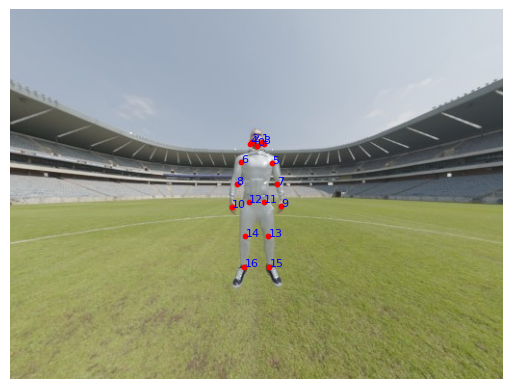

In [12]:
import json
import cv2
import matplotlib.pyplot as plt

def plot_keypoints_on_image(json_file, file_name_to_search):
    # Load the JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract the image and annotation information
    image_info = None
    annotation_info = None
    for image in data['images']:
        if image['file_name'] == file_name_to_search:
            image_info = image
            break

    if image_info is not None:
        for annotation in data['annotations']:
            if annotation['image_id'] == image_info['id']:
                annotation_info = annotation
                break

    if image_info is None or annotation_info is None:
        print("Image or annotation not found.")
        return

    # Read the image
    image_path = image_info['file_name']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract keypoints
    keypoints = annotation_info['keypoints']
    keypoints = [(keypoints[i], keypoints[i+1]) for i in range(0, len(keypoints), 3)]

    # Plot the keypoints on the image
    plt.imshow(image)
    for idx, (x, y) in enumerate(keypoints):
        if x > 0 and y > 0:  # Only plot visible keypoints
            plt.scatter(x, y, color='red', s=10)  # Adjust size with 's' parameter
            plt.text(x, y, str(idx), color='blue', fontsize=8)  # Adjust font size with 'fontsize' parameter

    plt.axis('off')
    plt.show()

json_file = '/content/preprocessed.json'
file_name_to_search = '/content/Keypoints_All/Back Squat/Back Squat/view1/render/0000.jpg'
plot_keypoints_on_image(json_file, file_name_to_search)


In [14]:
import cv2
import os
import json

# Load annotations
annotation_path = "/content/preprocessed.json"
with open(annotation_path, 'r') as file:
    annotations = json.load(file)

# Define the folder containing the view you want to visualize
view_folder = '/content/Keypoints_All/Back Squat/Back Squat/view1/render'

# Get a sorted list of all image files in the folder
image_files = sorted(os.listdir(view_folder))

# Initialize video writer
frame_size = None
out = None

for idx, image_file in enumerate(image_files):
    # Read the image
    image_path = os.path.join(view_folder, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Retrieve frame size if it's the first image
    if frame_size is None:
        frame_size = (image.shape[1], image.shape[0])
        out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, frame_size)

    # Retrieve the corresponding annotation
    image_info = next((img for img in annotations['images'] if img['file_name'] == image_path), None)
    annotation_info = None
    if image_info is not None:
        for annotation in annotations['annotations']:
            if annotation['image_id'] == image_info['id']:
                annotation_info = annotation
                break

    if annotation_info is not None:
        keypoints = annotation_info['keypoints']
        bbox = annotation_info['bbox']

        # Draw keypoints
        for i in range(0, len(keypoints), 3):
            x, y, visibility = keypoints[i:i+3]
            if visibility > 0:
                cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1)
                cv2.putText(image, str(i//3), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Draw bounding box
        x, y, w, h = map(int, bbox)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Write the frame to the video
    out.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Release the video writer
out.release()

print("Video saved as output_video.mp4")


Video saved as output_video.mp4


# **Stratified Sampling and Visualization**

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

class DataSplitter:
    def __init__(self, coco_data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"
        self.coco_data = coco_data
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio

    def split(self):
        df = pd.DataFrame(self.coco_data['images'])
        df['activity'] = df['file_name'].apply(self._extract_activity)
        df['view'] = df['file_name'].apply(self._extract_view)

        # Get unique combinations of activity and view
        combinations = df[['activity', 'view']].drop_duplicates()

        # If there's only one combination, split it into train, val, test
        if len(combinations) == 1:
            train_data, temp_data = train_test_split(df, test_size=self.val_ratio + self.test_ratio)
            val_data, test_data = train_test_split(temp_data, test_size=self.test_ratio / (self.val_ratio + self.test_ratio))
        else:
            # Split the combinations into train, val, test
            train_comb, temp_comb = train_test_split(combinations, test_size=self.val_ratio + self.test_ratio)
            val_comb, test_comb = train_test_split(temp_comb, test_size=self.test_ratio / (self.val_ratio + self.test_ratio))

            # Split the data based on the combinations
            train_data = pd.concat([df[(df['activity'] == row['activity']) & (df['view'] == row['view'])] for _, row in train_comb.iterrows()])
            val_data = pd.concat([df[(df['activity'] == row['activity']) & (df['view'] == row['view'])] for _, row in val_comb.iterrows()])
            test_data = pd.concat([df[(df['activity'] == row['activity']) & (df['view'] == row['view'])] for _, row in test_comb.iterrows()])

        return train_data, val_data, test_data

    @staticmethod
    def _extract_activity(file_name):
        return file_name.split('/')[3]

    @staticmethod
    def _extract_view(file_name):
        return file_name.split('/')[-3]


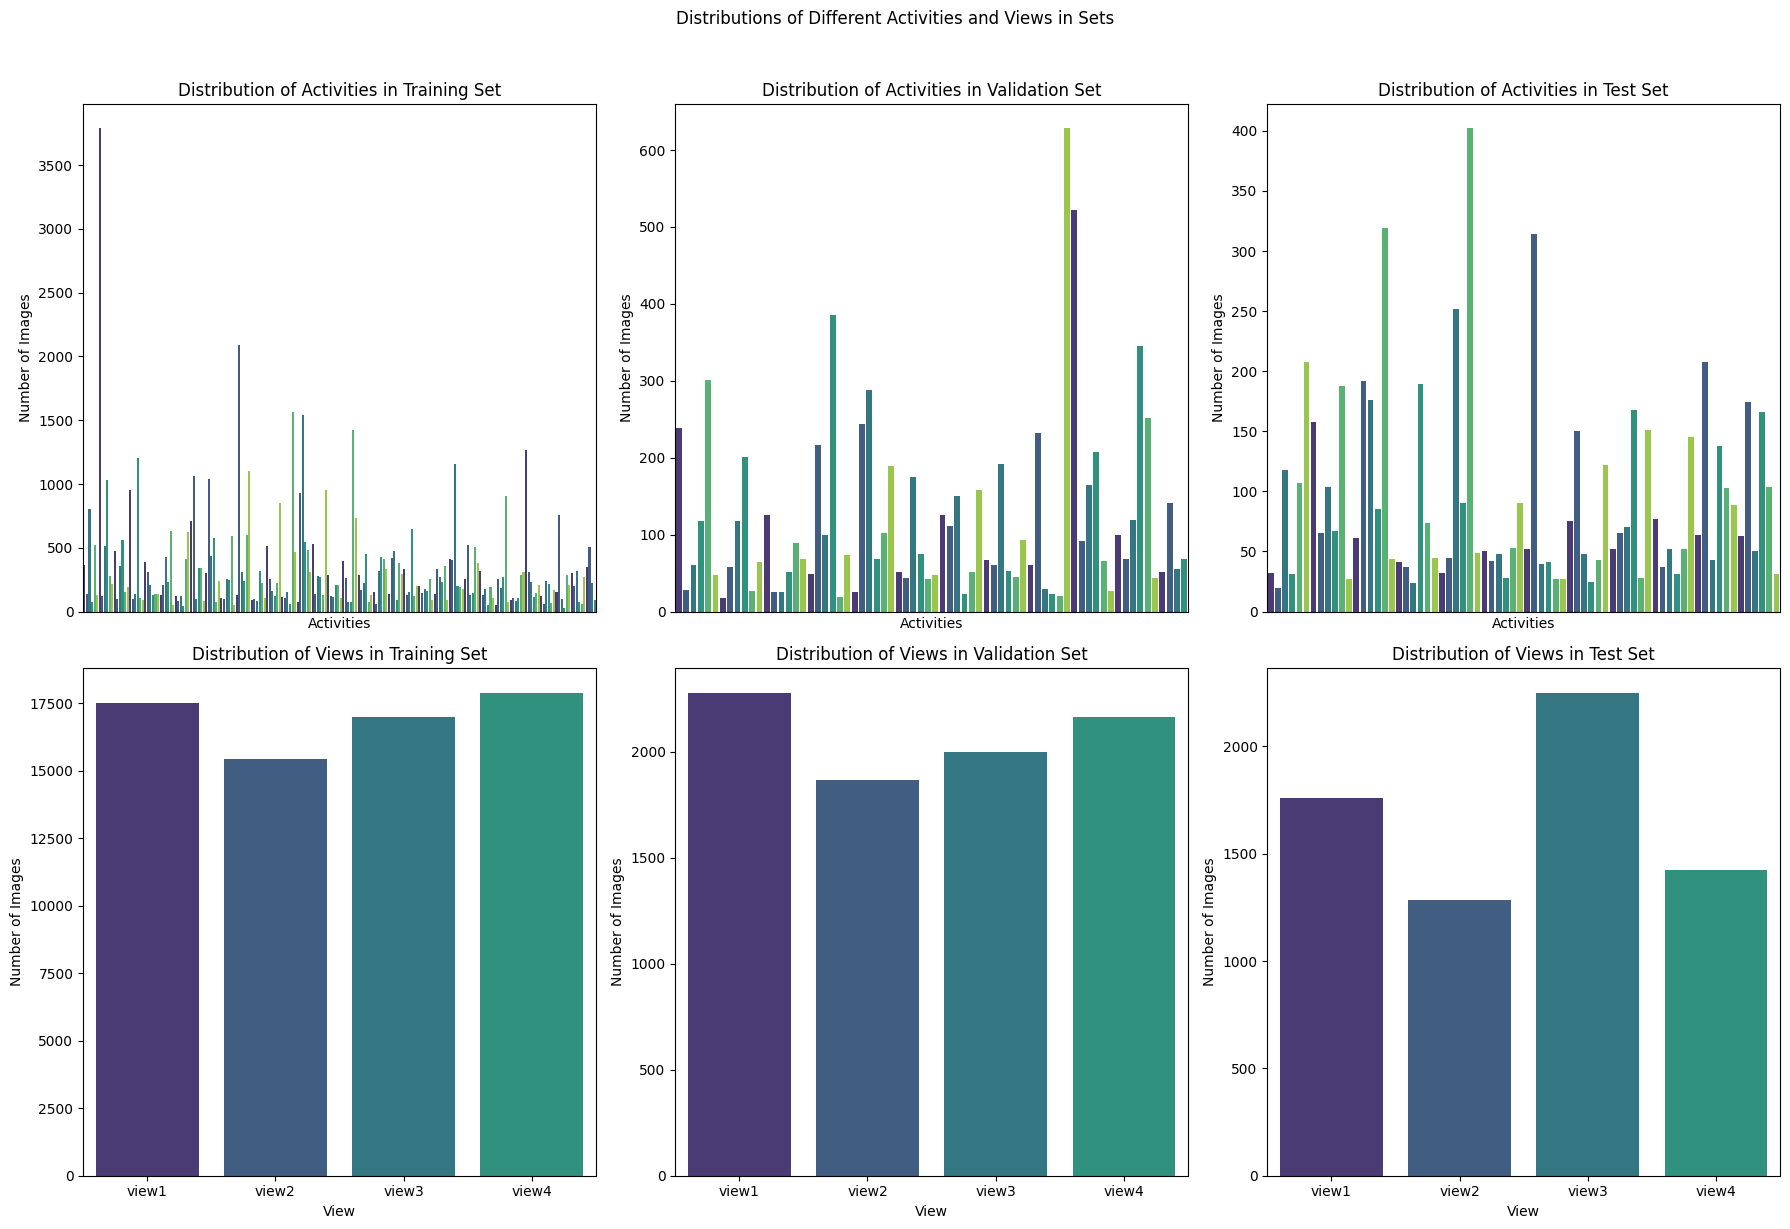

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_splits(train_data, val_data, test_data):
    # Assign labels for the splits
    train_data['split'] = 'Train'
    val_data['split'] = 'Validation'
    test_data['split'] = 'Test'

    # Combine data for easier plotting
    all_data = pd.concat([train_data, val_data, test_data])

    # Set a color palette
    palette = sns.color_palette("viridis") # Dark palette

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=False)

    # Titles
    fig.suptitle('Distributions of Different Activities and Views in Sets', y=1.02)
    axes[0, 0].set_title('Distribution of Activities in Training Set')
    axes[0, 1].set_title('Distribution of Activities in Validation Set')
    axes[0, 2].set_title('Distribution of Activities in Test Set')
    axes[1, 0].set_title('Distribution of Views in Training Set')
    axes[1, 1].set_title('Distribution of Views in Validation Set')
    axes[1, 2].set_title('Distribution of Views in Test Set')

    splits = ['Train', 'Validation', 'Test']

    # Plot activity distribution
    for ax, split in zip(axes[0, :], splits):
        sns.countplot(data=all_data[all_data['split'] == split], x='activity', ax=ax, palette=palette)
        ax.set_xticks([]) # Remove activity names from x-axis
        ax.set_xlabel('Activities')
        ax.set_ylabel('Number of Images')

    # Order of the views
    view_order = ['view1', 'view2', 'view3', 'view4']

    # Plot view distribution
    for ax, split in zip(axes[1, :], splits):
        sns.countplot(data=all_data[all_data['split'] == split], x='view', ax=ax, palette=palette, order=view_order)
        ax.set_xlabel('View')
        ax.set_ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

# Load the data and split it into train, validation, and test sets
# (Assuming coco_data has been loaded already)
data_splitter = DataSplitter(coco_data)
train_data, val_data, test_data = data_splitter.split()

# Call the function to visualize
visualize_splits(train_data, val_data, test_data)


In [64]:
def analyze_splits(train_data, val_data, test_data):
    # Print total image numbers in different splits
    print(f"Total images in Training set: {train_data.shape[0]}")
    print(f"Total images in Validation set: {val_data.shape[0]}")
    print(f"Total images in Test set: {test_data.shape[0]}")
    print("\n")

    # Print breakdown of views for each split
    for name, dataset in zip(["Training", "Validation", "Test"], [train_data, val_data, test_data]):
        print(f"{name} set view breakdown:")
        print(dataset['view'].value_counts())
        print("\n")

# Call the function to analyze
analyze_splits(train_data, val_data, test_data)


Total images in Training set: 67834
Total images in Validation set: 8312
Total images in Test set: 6718


Training set view breakdown:
view4    17897
view1    17503
view3    16985
view2    15449
Name: view, dtype: int64


Validation set view breakdown:
view1    2280
view4    2165
view3    1998
view2    1869
Name: view, dtype: int64


Test set view breakdown:
view3    2251
view1    1758
view4    1424
view2    1285
Name: view, dtype: int64




In [65]:
import json
import pandas as pd

# Generate separate COCO annotations for training and validation data
def generate_coco_subset(original_coco_data, subset_data):
    subset_images = subset_data['id'].tolist()
    subset_annotations = [anno for anno in original_coco_data['annotations'] if anno['image_id'] in subset_images]

    return {
        'info': original_coco_data['info'],
        'licenses': original_coco_data['licenses'],
        'images': [img for img in original_coco_data['images'] if img['id'] in subset_images],
        'annotations': subset_annotations,
        'categories': original_coco_data['categories']
    }

train_coco = generate_coco_subset(coco_data, train_data)
val_coco = generate_coco_subset(coco_data, val_data)

# Save the training and validation COCO data to separate JSON files
with open('/content/train_coco.json', 'w') as f:
    json.dump(train_coco, f)

with open('/content/val_coco.json', 'w') as f:
    json.dump(val_coco, f)


# **Splitting training set and validation set images**


In [69]:
import os
import shutil
import json

# Load the COCO data
with open('/content/train_coco.json', 'r') as f:
    train_data = json.load(f)

with open('/content/val_coco.json', 'r') as f:
    val_data = json.load(f)

# Create directories for training and validation images
train_dir = "/content/train2017"
val_dir = "/content/val2017"

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

def copy_and_rename_images(data, destination):
    """
    Copy images from their original paths to the destination directory and rename them based on their ID.
    Also, update the 'file_name' and 'coco_url' in the data to reflect the new format.
    """
    dir_name = os.path.basename(destination)
    base_url = "http://images.cocodataset.org/"

    for img in data['images']:
        source = img['file_name']
        new_name = f"{str(img['id']).zfill(12)}.jpg"
        destination_path = os.path.join(destination, new_name)
        shutil.copy(source, destination_path)
        img['file_name'] = new_name  # Update the 'file_name' in the data
        img['coco_url'] = base_url + dir_name + '/' + new_name

# Copy and rename the images
copy_and_rename_images(train_data, train_dir)
copy_and_rename_images(val_data, val_dir)

# Save the updated annotations back to their respective JSON files
with open('/content/train_coco.json', 'w') as f:
    json.dump(train_data, f)

with open('/content/val_coco.json', 'w') as f:
    json.dump(val_data, f)

Move training and validation image folders to your drive

In [73]:
!cp -r "/content/train2017" "/content/drive/MyDrive/SyntheticAlpha"

In [74]:
!cp -r "/content/val2017" "/content/drive/MyDrive/SyntheticAlpha"

In [75]:
!cp "/content/train_coco.json" "/content/drive/MyDrive/SyntheticAlpha/person_keypoints_train2017.json"

In [76]:
!cp "/content/train_coco.json" "/content/drive/MyDrive/SyntheticAlpha/person_keypoints_val2017.json"